In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv("data60.csv", low_memory=False)
# replace ? for NAN
df = df.replace('?', np.nan)
# Delete rows with missing values
df = df.dropna()
df = df.astype(float)

target_columns = df.iloc[:,-33:].columns
y = df.loc[:, target_columns].astype(float).sum(axis=1)
df.drop(columns=target_columns, inplace=True)

df["ut_ms"] = [datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d, %H:%M:%S') for x in df["ut_ms"]]
df["ut_ms"] = pd.to_datetime(df["ut_ms"])

Avtokorelacijska funkcija (ACF) kaže, kako podobna je vrednost v dani časovni seriji prejšnji vrednosti. Meri stopnjo podobnosti med dano časovno serijo in zamaknjeno verzijo te časovne serije pri različnih opazovalnih intervalih.

In [110]:
data = pd.DataFrame({
    "date" : df["ut_ms"].iloc[:20000],
    "target" : y.loc[:20000]
})
data = data.dropna()


In [111]:
train_size = int(0.85 * len(data))
test_size = len(data) - train_size

train = data.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(data.iloc[:train_size, 0]), pd.DataFrame(data.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(data.iloc[train_size:, 0]), pd.DataFrame(data.iloc[train_size:, 1])

print(len(train), len(x_valid))

16969 2995


In [126]:
data

,target
date,
2008-08-22 05:01:00,4.699767
2008-08-22 06:01:00,4.606195
2008-08-22 07:01:00,5.093628
2008-08-22 08:01:00,4.506636
2008-08-22 09:01:00,4.703911
...,...
2010-12-03 05:01:00,5.114879
2010-12-03 06:01:00,6.203923
2010-12-03 07:01:00,4.129451


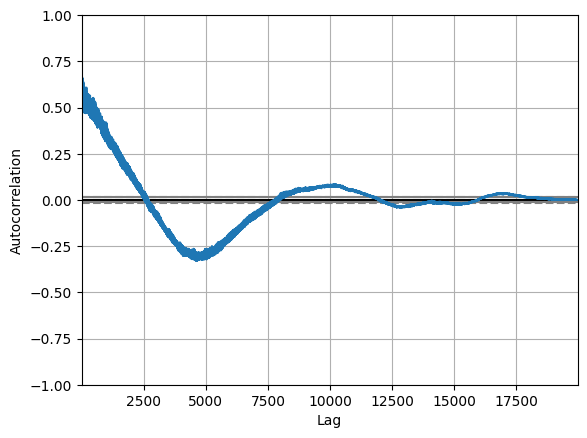

In [112]:
#avtokorelacijski plot

autocorrelation_plot(data['target'])
plt.show()

In [114]:
data = data.set_index("date")
model = sm.tsa.arima.ARIMA(data, order=(1, 1, 1)) 
results_ARIMA = model.fit()

results_ARIMA.summary()

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 target   No. Observations:                19964
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17730.251
Date:                Sun, 07 Jan 2024   AIC                          35466.502
Time:                        13:13:09   BIC                          35490.207
Sample:                             0   HQIC                         35474.258
                              - 19964                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3796      0.006     62.508      0.000       0.368       0.392
ma.L1         -0.9850      0.001   -795.777      0.000      -0.987      -0.983
sigma2         0.3459      0.003    111.306      0.000       0.340       0.352
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):               684.21
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.37
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

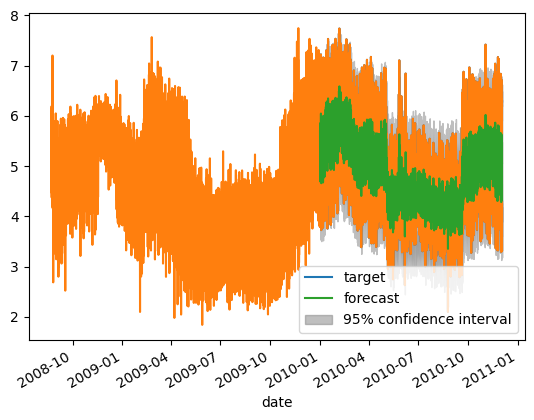

In [127]:
fig, ax = plt.subplots()
ax = data.loc['2010':'2011'].plot(ax=ax)
ax.plot(data["target"])
plot_predict(results_ARIMA,'2010', '2010-12-03 09:01:00', ax=ax)
plt.show()

<Axes: xlabel='date'>

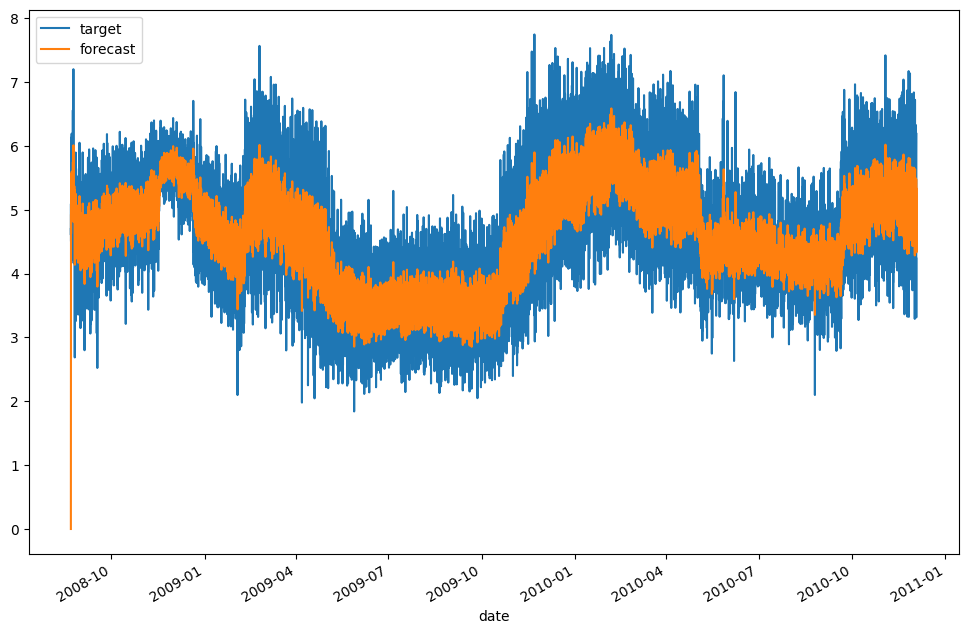

In [128]:
data['forecast']=results_ARIMA.predict(dynamic=False)
data[['target','forecast']].plot(figsize=(12,8))

In [129]:
#auto airma

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=32647.373, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=100109.552, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36073.120, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=79989.245, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=30134.516, Time=2.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=33779.167, Time=2.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=30159.654, Time=4.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=30550.326, Time=2.63 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=4.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=30231.253, Time=13.77 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 33.628 seconds
                               SARIMAX Results                                
Dep. Variabl

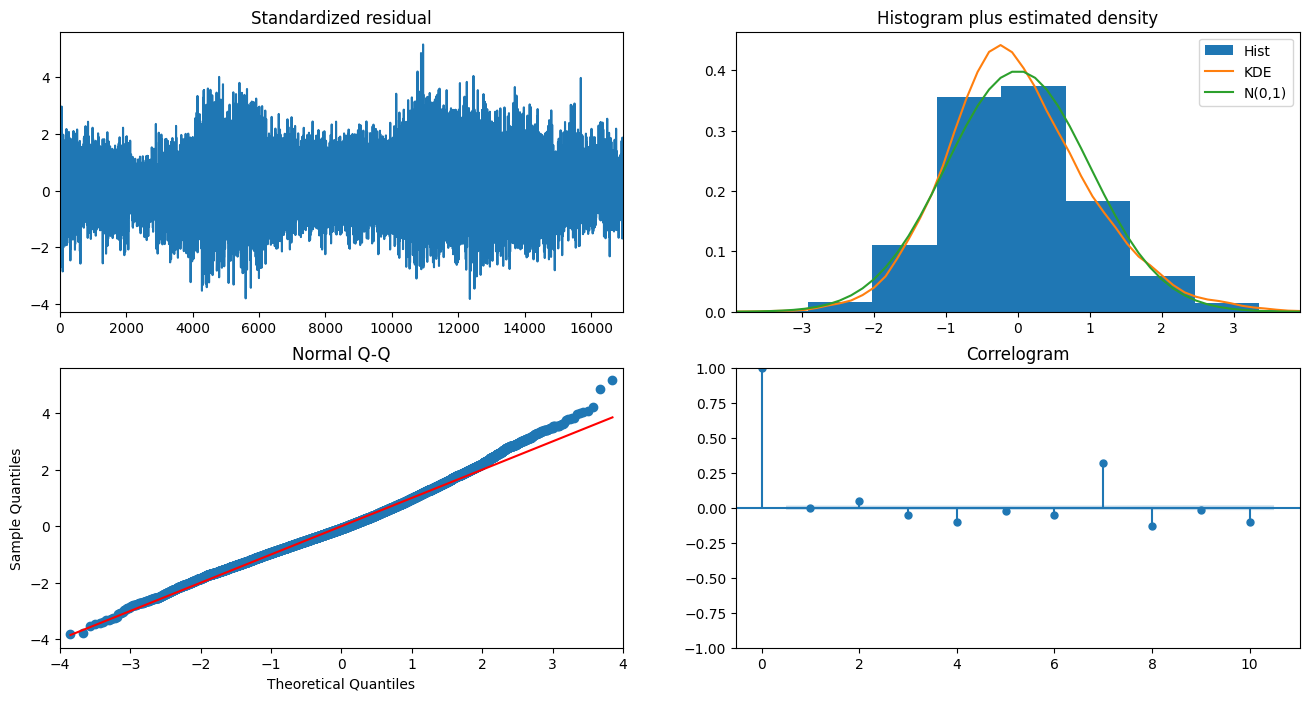

In [130]:
model.plot_diagnostics(figsize=(16,8))
plt.show()